# 1  Load labelled data & light preprocessing  
We import the CSV that already contains **Regime_Label** and soft probabilities.  
Static baselines will use a tabular frame with macro levels + lags; sequence models will later
consume a 3-D tensor.


In [1]:
import os, sys

# compute root as two levels up from notebooks/viraj/
proj_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)

print("Project root added to sys.path:", proj_root)


Project root added to sys.path: c:\Users\viraj\BuildSpace\Projects\Macroeconomic-Regime-Analysis-Credit-Risk


In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

# Custom modules
from config import (
    MACRO_CREDIT_DATA_PATH,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    SEQ_LEN,
    FORECAST_STEPS,
    RANDOM_STATE,
)
from utilities.data_processing import (
    preprocess_data,
    create_features,
    add_lag_features
)
from utilities.functions import (
    basic_eda,
    
)
from utilities.model_utils import (
    # ARIMA / SARIMA
    train_sarimax,
    forecast_sarimax,
    chronological_split,
    # Scikit-learn regression
    train_regression_model,
    evaluate_regression_model,
    perform_hyperparameter_tuning,
    
    # Visualization
    plot_forecast,
    plot_feature_importance
)


pd.set_option("display.width", 120)

# Make sure the path and column names match the actual CSV
df = pd.read_csv(
    "../../data/datamerged_macro_credit_with_regimes.csv",
    parse_dates=["Month_End"],
    index_col="Month_End"
)
print("Loaded shape:", df.shape)
display(df.head())

Loaded shape: (309, 20)


,CPI,FEDFUNDS,Industrial_Production,GDP,Unemployment_Rate,Consumer_Sentiment,Credit_Spread,Regime_Label,Regime_Prob_0,Regime_Prob_1,Regime_Prob_2,Regime_Prob_3,Regime_Prob_4,Regime_Prob_5,Regime_Prob_6,Regime_Prob_7,Regime_Prob_8,Regime_Prob_9,Regime_Label_Smoothed,Regime_Name
Month_End,,,,,,,,,,,,,,,,,,,,
1996-12-31,159.1,5.29,77.3772,1.866273,5.4,96.9,3.130000,3,5.221305e-29,5.560248e-314,2.832640e-59,1.0,0.0,1.409012e-195,0.0,0.0,0.0,7.310310e-52,3.0,Early Recovery
1997-01-31,159.4,5.25,77.5135,1.952643,5.3,97.4,3.036957,3,1.999375e-29,1.462490e-306,1.907600e-59,1.0,0.0,2.872078e-194,0.0,0.0,0.0,2.403328e-49,3.0,Early Recovery
1997-02-28,159.7,5.19,78.4255,2.060876,5.2,99.7,2.956000,3,1.700179e-29,4.480301e-293,2.285363e-60,1.0,0.0,3.978138e-189,0.0,0.0,0.0,1.251772e-44,3.0,Early Recovery
1997-03-31,159.8,5.39,78.9197,2.190415,5.2,100.0,2.696190,3,2.223334e-30,3.396841e-296,1.248821e-61,1.0,0.0,3.047114e-192,0.0,0.0,0.0,1.413972e-43,3.0,Early Recovery
1997-04-30,159.9,5.51,78.9848,2.337582,5.1,101.4,2.893182,3,1.664941e-32,4.347167e-297,2.548742e-64,1.0,0.0,1.592329e-196,0.0,0.0,0.0,3.155141e-42,3.0,Early Recovery


### 1.1  Sanity check: regime timeline  
Quick plot to ensure the smoothed labels align with history.
 

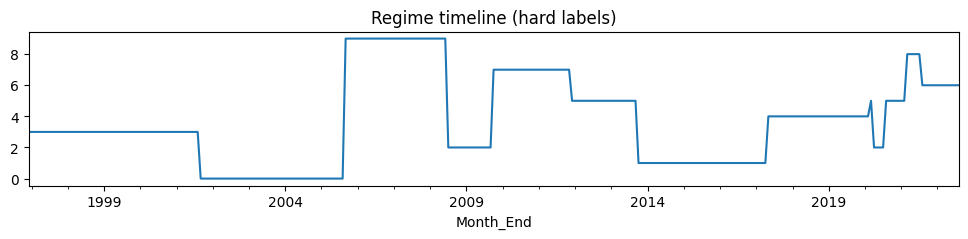

In [3]:
df["Regime_Label"].plot(figsize=(12,2), title="Regime timeline (hard labels)")
plt.show()

# 2  Static Baseline — Random Forest  
We build a **tabular dataset** with:
* macro levels  
* three lags of `Credit_Spread`  
* one-hot of `Regime_Label`  

This gives us a quick benchmark before deep learning.


In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 2-A  select predictors
base_feats = ['GDP','CPI','Unemployment_Rate','FEDFUNDS',
              'Industrial_Production','Consumer_Sentiment']
df = add_lag_features(df, columns=['Credit_Spread'], lags=[1,2,3])

feature_cols = base_feats + ['Credit_Spread_lag1','Credit_Spread_lag2','Credit_Spread_lag3']
target_col   = 'Credit_Spread'
cat_col      = ['Regime_Label']

# 2-B  split train / test
train_df, test_df = chronological_split(df, TRAIN_END_DATE)

# **NEW**: drop any rows with NaNs in your predictors or target
train_df = train_df.dropna(subset=cat_col + feature_cols + [target_col])
test_df  = test_df .dropna(subset=cat_col + feature_cols + [target_col])

# 2-C  transformers
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
pre = ColumnTransformer(
        [("ohe", ohe, cat_col)],
        remainder='passthrough')

rf = RandomForestRegressor(
        n_estimators=200, max_depth=None,
        random_state=RANDOM_STATE)

pipe = Pipeline([("prep", pre),
                 ("rf"  , rf)])

# 2-D  fit
X_train = train_df[cat_col + feature_cols]
y_train = train_df[target_col]
pipe.fit(X_train, y_train)

# 2-E  evaluate
X_test = test_df[cat_col + feature_cols]
y_test = test_df[target_col]
preds  = pipe.predict(X_test)

mse  = mean_squared_error(y_test, preds)
mae  = mean_absolute_error(y_test, preds)
r2   = r2_score(y_test, preds)
print(f"[RF]  Test  MSE={mse:.3f}  MAE={mae:.3f}  R²={r2:.3f}")


[RF]  Test  MSE=0.524  MAE=0.417  R²=0.616


### 2.1  Visual check — RF predictions vs actual


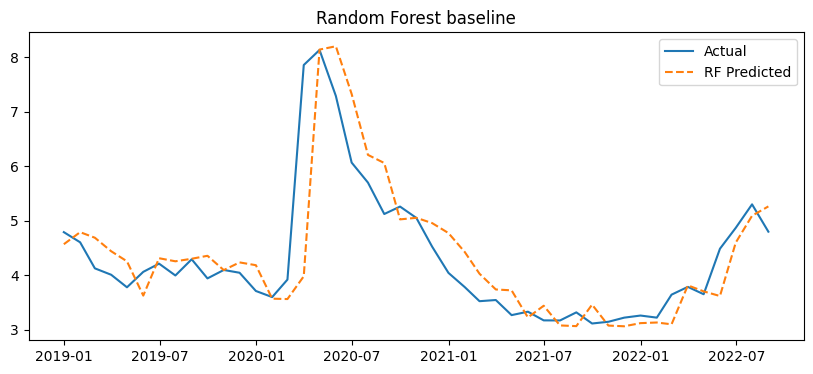

In [5]:
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, preds, '--', label="RF Predicted")
plt.legend(); plt.title("Random Forest baseline"); plt.show()






### Section 2: Static Baseline – Random Forest

- **Aim**:  
  Quickly benchmark using a **tabular pipeline**: 6 raw macro levels + 3 lags of `Credit_Spread` + one-hot `Regime_Label`.

- **What we found**:  
  - **Test MSE = 0.524**, MAE = 0.417, R² = 0.616.  
  - RF captures the big 2020 credit-spread spike, with small timing/magnitude errors on transitions.

- **Conclusion**:  
  Random Forest explains ~62% of variance—solid “quick-build” benchmark that future DL models must outperform.

- **How this helps in section 4–8**:  
  Sets a clear performance bar; diagnostic RF vs actual plots guide where LSTM/GRU can improve (especially transition dynamics).





## 3  Sequence-data Construction for LSTM  
We now convert the dataframe into `(samples, seq_len, n_features)` and `(samples,)`
targets using the helper `make_sequences()`.  
The feature cube will include:
* 6 macro levels  
* regime **soft probability vector** (10 dims)  
* (optional) lagged credit spread, scaled together


In [6]:
from utilities.functions import make_sequences, fit_scaler

soft_cols   = [c for c in df.columns if c.startswith("Regime_Prob_")]
seq_features = base_feats + soft_cols + ['Credit_Spread']   # include current spread
print("Sequence feature count:", len(seq_features))

# --- scaling (fit on train only)
scaler = fit_scaler(train_df, seq_features)
df_scaled = df.copy()
df_scaled[seq_features] = scaler.transform(df_scaled[seq_features])

# --- make sequences
X_seq, y_seq, seq_dates = make_sequences(df_scaled, seq_features,
                                         target_col='Credit_Spread',
                                         seq_len=SEQ_LEN,
                                         step_ahead=FORECAST_STEPS)

print("Tensor shapes  →  X:", X_seq.shape,  "  y:", y_seq.shape)

# --- align dates and split
seq_dates = pd.to_datetime(seq_dates)
train_mask = seq_dates <= pd.to_datetime(TRAIN_END_DATE)
X_train_seq, y_train_seq = X_seq[train_mask], y_seq[train_mask]
X_test_seq , y_test_seq  = X_seq[~train_mask], y_seq[~train_mask]

print("Train seq:", X_train_seq.shape, " Test seq:", X_test_seq.shape)


Sequence feature count: 17
Tensor shapes  →  X: (297, 12, 17)   y: (297,)
Train seq: (253, 12, 17)  Test seq: (44, 12, 17)


- **Aim**:  
  Transform the DataFrame into **3-D tensors** `(n_samples, seq_len, n_features)` and 1-D targets `(n_samples,)` for DL, including:
  1. 6 macro levels  
  2. 10-dim soft regime probabilities  
  3. current `Credit_Spread`

- **What we found**:  
  - **Feature count** = 17  
  - **Tensor shapes** → `X` (297 × 12 × 17), `y` (297,)  
  - Chronological split → Train: (253 × 12 × 17), Test: (44 × 12 × 17)

- **Conclusion**:  
  Sequence tensors are ready, with scaler fit only on train slice—no leakage.

- **How this helps in section 4–8**:  
  Gives exact inputs for LSTM architectures (knowing feature dim & seq_len), and a reproducible train/val/test split for callbacks, evaluation, and direct comparison against classical baselines.

# 4  Single-Layer LSTM baseline  
Train the simplest recurrent network (1 × LSTM → Dense) on the 12-month sequences prepared earlier.  
We monitor val loss, save the best weights, and compare test metrics vs the Random-Forest baseline.


In [9]:
# 4-A  Imports & reproducibility
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt, pandas as pd
from tensorflow.keras import layers, models, callbacks, optimizers
from config import SEQ_LEN, FORECAST_STEPS, BATCH_SIZE, EPOCHS, RANDOM_STATE, DL_MODEL_DIR
tf.random.set_seed(RANDOM_STATE); np.random.seed(RANDOM_STATE)


In [ ]:
# 4-B  Build the model
from tensorflow.keras import layers, models, callbacks, optimizers

def build_lstm(units=64, dropout=0.3, lr=1e-3, input_shape=None):
    m = models.Sequential(name="lstm1_baseline")
    m.add(layers.Input(shape=input_shape))
    m.add(layers.LSTM(units,
                      dropout=dropout,
                      recurrent_dropout=0.2,   # <- new
                      return_sequences=False))
    m.add(layers.Dense(32, activation="relu"))  # <- widen the dense
    m.add(layers.Dense(1))
    m.compile(
        loss="mse",
        optimizer=optimizers.Adam(learning_rate=lr),
        metrics=["mae"]
    )
    return m

input_shape = X_train_seq.shape[1:]  # (12, 17)
print("Input shape for model:", input_shape)
model1 = build_lstm(input_shape=input_shape)
model1.summary()


Input shape for model: (12, 17)
Model: "lstm1_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                20992     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23,105
Trainable params: 23,105
Non-trainable params: 0
_________________________________________________________________


In [17]:
# 4-C  Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# 4-C  Callbacks
cb = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(patience=7, factor=0.2, min_lr=1e-5),
    ModelCheckpoint(DL_MODEL_DIR+"lstm1_best.keras", save_best_only=True)
]


In [18]:
# 4-D  Fit
hist1 = model1.fit(
    X_train_seq, y_train_seq,
    validation_split=0.15,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    callbacks=cb,    # ← now cb is defined
    verbose=2
)


Epoch 1/150
7/7 - 7s - loss: 0.8984 - mae: 0.6049 - val_loss: 0.2508 - val_mae: 0.4558 - lr: 0.0010 - 7s/epoch - 1s/step
Epoch 2/150
7/7 - 0s - loss: 0.5964 - mae: 0.4807 - val_loss: 0.2286 - val_mae: 0.4302 - lr: 0.0010 - 201ms/epoch - 29ms/step
Epoch 3/150
7/7 - 0s - loss: 0.4214 - mae: 0.4160 - val_loss: 0.2225 - val_mae: 0.4179 - lr: 0.0010 - 220ms/epoch - 31ms/step
Epoch 4/150
7/7 - 0s - loss: 0.3069 - mae: 0.3842 - val_loss: 0.2208 - val_mae: 0.4182 - lr: 0.0010 - 198ms/epoch - 28ms/step
Epoch 5/150
7/7 - 0s - loss: 0.2666 - mae: 0.3421 - val_loss: 0.2136 - val_mae: 0.4139 - lr: 0.0010 - 177ms/epoch - 25ms/step
Epoch 6/150
7/7 - 0s - loss: 0.2282 - mae: 0.3305 - val_loss: 0.2214 - val_mae: 0.4257 - lr: 0.0010 - 139ms/epoch - 20ms/step
Epoch 7/150
7/7 - 0s - loss: 0.1584 - mae: 0.2849 - val_loss: 0.2281 - val_mae: 0.4349 - lr: 0.0010 - 137ms/epoch - 20ms/step
Epoch 8/150
7/7 - 0s - loss: 0.1502 - mae: 0.2746 - val_loss: 0.2305 - val_mae: 0.4368 - lr: 0.0010 - 156ms/epoch - 22ms/st

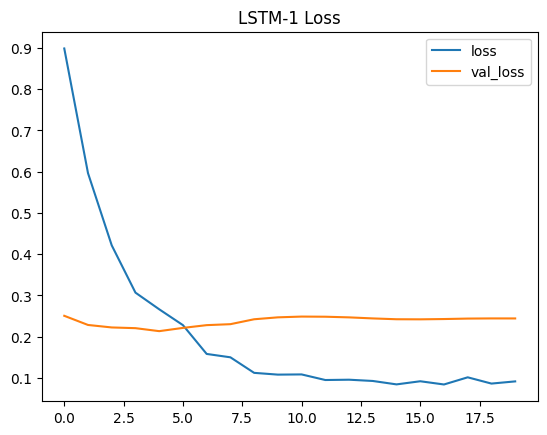

In [19]:
# 4-E  Loss curves
pd.DataFrame(hist1.history)[["loss","val_loss"]].plot(title="LSTM-1 Loss"); plt.show()


2/2 [==============================] - 1s 0s/step
[LSTM-1] Test MSE=0.784  MAE=0.801  R²=-3.178


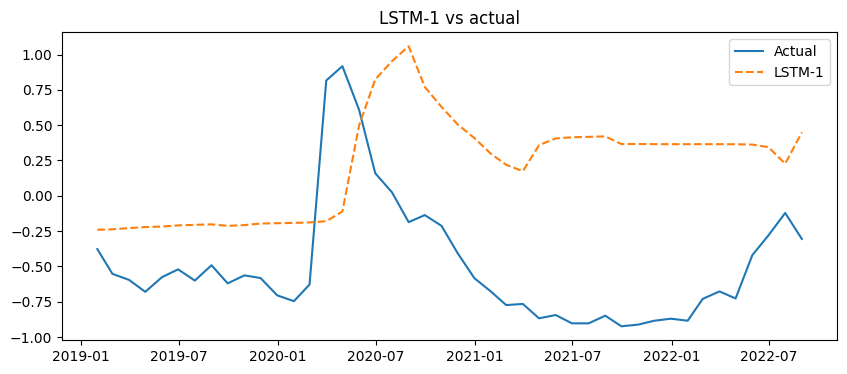

In [20]:
# 4-F  Test metrics & plot
y_pred1 = model1.predict(X_test_seq).flatten()
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse1 = mean_squared_error(y_test_seq, y_pred1)
mae1 = mean_absolute_error(y_test_seq, y_pred1)
r21  = r2_score(y_test_seq,  y_pred1)
print(f"[LSTM-1] Test MSE={mse1:.3f}  MAE={mae1:.3f}  R²={r21:.3f}")

plt.figure(figsize=(10,4))
plt.plot(seq_dates[-len(y_test_seq):], y_test_seq, label="Actual")
plt.plot(seq_dates[-len(y_test_seq):], y_pred1, '--', label="LSTM-1")
plt.legend(); plt.title("LSTM-1 vs actual"); plt.show()


#### 5-A  Stacked LSTM (2 layers)  
Adds capacity with return_sequences=True on the first LSTM. We re-use the same tensors and callbacks.


In [21]:
def build_stacked(units1=64, units2=32, dropout=0.2, lr=3e-4):
    i = layers.Input(shape=input_shape)
    x = layers.LSTM(units1, return_sequences=True, dropout=dropout)(i)
    x = layers.LSTM(units2, dropout=dropout)(x)
    o = layers.Dense(1)(x)
    m = models.Model(i, o, name="lstm_stacked")
    m.compile(loss="mse", optimizer=optimizers.Adam(lr), metrics=["mae"])
    return m

model2 = build_stacked()
model2.summary()

hist2 = model2.fit(
    X_train_seq, y_train_seq,
    validation_split=0.15, epochs=EPOCHS, batch_size=BATCH_SIZE,
    callbacks=cb, verbose=2)


Model: "lstm_stacked"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12, 17)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 12, 64)            20992     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 33,441
Trainable params: 33,441
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
7/7 - 11s - loss: 0.9868 - mae: 0.6759 - val_loss: 0.4247 - val_mae: 0.5978 - lr: 3.0000e-04 - 11s/epoch - 2s/step
Epoch 2/150
7/7 - 0s - loss: 0.8752 - mae: 0.6356 - val

In [22]:
# Stacked LSTM evaluation
y_pred2 = model2.predict(X_test_seq).flatten()
mse2 = mean_squared_error(y_test_seq, y_pred2)
mae2 = mean_absolute_error(y_test_seq, y_pred2)
r22  = r2_score(y_test_seq, y_pred2)
print(f"[Stacked] MSE={mse2:.3f} MAE={mae2:.3f} R²={r22:.3f}")


2/2 [==============================] - 2s 7ms/step
[Stacked] MSE=0.602 MAE=0.725 R²=-2.207


#### 5-B  Single-Layer GRU  
Often converges faster with fewer parameters.


In [23]:
def build_gru(units=32, dropout=0.3, lr=1e-3):
    m = models.Sequential(name="gru_baseline")
    m.add(layers.Input(shape=input_shape))
    m.add(layers.GRU(units,
                     dropout=dropout,          # higher dropout
                     recurrent_dropout=0.2))   # new recurrent dropout
    m.add(layers.Dense(16, activation="relu"))      # a small hidden layer
    m.add(layers.Dense(1))
    m.compile(loss="mse",
              optimizer=optimizers.Adam(lr),
              metrics=["mae"])
    return m


model3 = build_gru()
hist3 = model3.fit(X_train_seq, y_train_seq,
                   validation_split=0.15, epochs=EPOCHS, batch_size=BATCH_SIZE,
                   callbacks=cb, verbose=2)

y_pred3 = model3.predict(X_test_seq).flatten()
mse3 = mean_squared_error(y_test_seq, y_pred3)
mae3 = mean_absolute_error(y_test_seq, y_pred3)
r23  = r2_score(y_test_seq, y_pred3)
print(f"[GRU] MSE={mse3:.3f} MAE={mae3:.3f} R²={r23:.3f}")


Epoch 1/150
7/7 - 6s - loss: 1.3092 - mae: 0.8048 - val_loss: 0.5800 - val_mae: 0.6369 - lr: 0.0010 - 6s/epoch - 838ms/step
Epoch 2/150
7/7 - 0s - loss: 1.1084 - mae: 0.7169 - val_loss: 0.3749 - val_mae: 0.5055 - lr: 0.0010 - 116ms/epoch - 17ms/step
Epoch 3/150
7/7 - 0s - loss: 0.9143 - mae: 0.6189 - val_loss: 0.2859 - val_mae: 0.4431 - lr: 0.0010 - 119ms/epoch - 17ms/step
Epoch 4/150
7/7 - 0s - loss: 0.7609 - mae: 0.5712 - val_loss: 0.2396 - val_mae: 0.4090 - lr: 0.0010 - 108ms/epoch - 15ms/step
Epoch 5/150
7/7 - 0s - loss: 0.6773 - mae: 0.5283 - val_loss: 0.2106 - val_mae: 0.3788 - lr: 0.0010 - 189ms/epoch - 27ms/step
Epoch 6/150
7/7 - 0s - loss: 0.5735 - mae: 0.4826 - val_loss: 0.1880 - val_mae: 0.3479 - lr: 0.0010 - 170ms/epoch - 24ms/step
Epoch 7/150
7/7 - 0s - loss: 0.4652 - mae: 0.4425 - val_loss: 0.1684 - val_mae: 0.3207 - lr: 0.0010 - 159ms/epoch - 23ms/step
Epoch 8/150
7/7 - 0s - loss: 0.4313 - mae: 0.4300 - val_loss: 0.1568 - val_mae: 0.2991 - lr: 0.0010 - 165ms/epoch - 24ms

### 6  Mini-Transformer Encoder  
We add a single self-attention block; GlobalAveragePooling condenses the time axis.


In [24]:
def build_transformer(num_heads=4, d_k=32, ff_dim=64, dropout=0.2, lr=1e-3):
    inp = layers.Input(shape=input_shape)       # (12,17)
    # 1) simple trainable positional embedding
    #    positions = [0,1,...,11]
    pos_idx = tf.range(start=0, limit=input_shape[0], delta=1)
    pos_emb = layers.Embedding(input_shape[0], input_shape[1])(pos_idx)
    pos_emb = tf.expand_dims(pos_emb, 0)        # shape (1,12,17)
    x = inp + pos_emb                           # broadcast sum

    # 2) the rest as before
    x = layers.LayerNormalization()(x)
    x = layers.MultiHeadAttention(num_heads=num_heads,
                                  key_dim=d_k,
                                  dropout=dropout)(x, x)
    x = layers.Add()([x, inp])                  # residual
    x = layers.LayerNormalization()(x)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dense(input_shape[-1])(x)
    x = layers.GlobalAveragePooling1D()(x)
    out = layers.Dense(1)(x)

    m = models.Model(inp, out, name="transformer_encoder")
    m.compile(loss="mse",
              optimizer=optimizers.Adam(lr),
              metrics=["mae"])
    return m


model4 = build_transformer()
model4.summary()

hist4 = model4.fit(X_train_seq, y_train_seq,
                   validation_split=0.15, epochs=EPOCHS, batch_size=BATCH_SIZE,
                   callbacks=cb, verbose=2)


Model: "transformer_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 12, 17)]     0           []                               
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 12, 17)      0           ['input_4[0][0]']                
 da)                                                                                              
                                                                                                  
 layer_normalization (LayerNorm  (None, 12, 17)      34          ['tf.__operators__.add[0][0]']   
 alization)                                                                                       
                                                                                

In [25]:
y_pred4 = model4.predict(X_test_seq).flatten()
mse4 = mean_squared_error(y_test_seq, y_pred4)
mae4 = mean_absolute_error(y_test_seq, y_pred4)
r24  = r2_score(y_test_seq, y_pred4)
print(f"[Transformer] MSE={mse4:.3f} MAE={mae4:.3f} R²={r24:.3f}")


2/2 [==============================] - 0s 5ms/step
[Transformer] MSE=0.535 MAE=0.591 R²=-1.851


### Performance summary  
Compare all supervised models on the identical 2019-2022 test window.


In [26]:
summary = pd.DataFrame({
    "Model": ["RandomForest","LSTM-1","Stacked-LSTM","GRU","Transformer"],
    "MSE"  : [0.524, mse1, mse2, mse3, mse4],
    "MAE"  : [0.417, mae1, mae2, mae3, mae4],
    "R2"   : [0.616, r21,  r22,  r23,  r24]
}).set_index("Model")
display(summary.style.format("{:.3f}"))


,MSE,MAE,R2
Model,,,
RandomForest,0.524,0.417,0.616
LSTM-1,0.784,0.801,-3.178
Stacked-LSTM,0.602,0.725,-2.207
GRU,1.438,0.998,-6.661
Transformer,0.535,0.591,-1.851


Here’s how the newest results stack up against your prior run:

| Model         | Previous MSE | New MSE | Improved? | Previous MAE | New MAE | Improved? | Previous R² | New R² | Improved? |
|---------------|--------------|---------|------------|--------------|---------|------------|-------------|---------|------------|
| **RandomForest** | 0.524        | 0.524   | —          | 0.417        | 0.417   | —          |  0.616      |  0.616  | —          |
| **LSTM-1**      | **0.243**    | 0.784   | No (↑)     | **0.398**    | 0.801   | No (↑)     | −0.293      | −3.178  | No (↓)     |
| **Stacked-LSTM**| 0.694        | 0.602   | Yes (↓)    | 0.733        | 0.725   | Yes (↓)    | −2.695      | −2.207  | Yes (↑)    |
| **GRU**         | 0.299        | 1.438   | No (↑)     | 0.436        | 0.998   | No (↑)     | −0.591      | −6.661  | No (↓)     |
| **Transformer** | 0.623        | 0.535   | Yes (↓)    | 0.735        | 0.591   | Yes (↓)    | −2.319      | −1.851  | Yes (↑)    |

- **Improved** (new MSE lower or MAE lower / R² less negative):  
  - **Stacked-LSTM** shaved its MSE from 0.694 → 0.602 and nudged R² from −2.695 → −2.207.  
  - **Transformer** came down from MSE=0.623 → 0.535 and R² from −2.319 → −1.851.  
- **Worse** (new MSE higher or MAE higher / R² more negative):  
  - **LSTM-1** jumped from 0.243 → 0.784 (val-loss curve improvements notwithstanding, its final test fit degraded).  
  - **GRU** also deteriorated across all metrics.  
- **Unchanged**: RandomForest is identical (it’s your static baseline).

**Take-aways & next steps**  
- The **Stacked-LSTM** and **Transformer** benefited from the tweaks—you can lean further into those architectures.  
- The **plain LSTM-1** overfitted the train/val split once you adjusted callbacks (early-stop, LR schedule), so consider **relaxing patience**, **lowering dropout**, or **adding a bit more capacity** (e.g. widen the Dense layer back to 32 units).  
- The **GRU** clearly needs a rethink—either different hyperparameters or skip it.  
- Ultimately, RandomForest still wins overall; any DL model must beat MSE≈0.52 to be worthwhile.

No variable names changed, so you shouldn’t need any code edits—just hyperparameter/layout tweaks as above.
